In [2]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize
dp = '/home/ebert/jupyter-notebooks/FNode-data'

def gaussian(x, a, x0, s, b):
    return b + a*np.exp(-0.5*((x-x0)/s)**2)

name 'fort_exp' is not defined
name 'rb_uwave_freq' is not defined
ivars: [u'uwave_offset_khz']
ivar: -10.0000	cloading: 0.153	rloading: 0.370		cretention: 0.828 +- 0.048	rretention: 0.900 +- 0.030
ivar: -8.3333	cloading: 0.115	rloading: 0.140		cretention: 0.586 +- 0.050	rretention: 0.789 +- 0.041
ivar: -6.6667	cloading: 0.098	rloading: 0.155		cretention: 0.622 +- 0.049	rretention: 0.803 +- 0.040
ivar: -5.0000	cloading: 0.130	rloading: 0.110		cretention: 0.417 +- 0.050	rretention: 0.493 +- 0.050
ivar: -3.3333	cloading: 0.101	rloading: 0.215		cretention: 0.303 +- 0.035	rretention: 0.429 +- 0.050
ivar: -1.6667	cloading: 0.111	rloading: 0.215		cretention: 0.278 +- 0.035	rretention: 0.129 +- 0.034
ivar: 0.0000	cloading: 0.187	rloading: 0.290		cretention: 0.356 +- 0.042	rretention: 0.157 +- 0.037
ivar: 1.6667	cloading: 0.111	rloading: 0.187		cretention: 0.429 +- 0.043	rretention: 0.155 +- 0.036
ivar: 3.3333	cloading: 0.098	rloading: 0.165		cretention: 0.643 +- 0.048	rretention: 0.254 +- 0.0

<IPython.core.display.Javascript object>


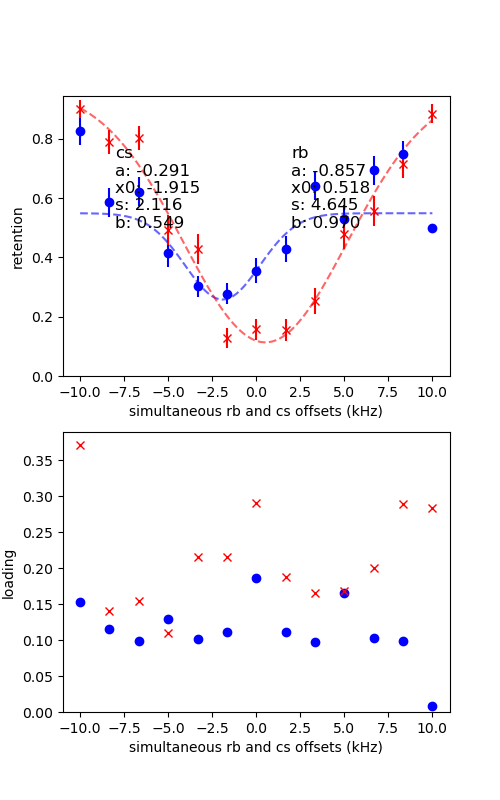

[-0.29127908 -1.91507281  2.11557662  0.54928451]
[-0.85680365  0.51809323  4.64500055  0.97028577]


In [13]:
exp_name = ''
if exp_name:
    exp_date = '_'.join(exp_name.split('_')[:3])
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
else:
    experiment_file = ''
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
cs_cuts = [[29],[3]]
rb_cuts = [[40],[3]]
q.set_thresholds(cs_cuts, roi=0)
q.set_thresholds(rb_cuts, roi=1)
retention = q.apply_thresholds()
cuts = q.get_thresholds()
roi_map = ['cs', 'rb']
fmt_map = ['bo', 'rx']
entries = np.product(retention['retention'].shape[:-1])
tbl_str = "ivar: {0:.4f}\tcloading: {1:.3f}\trloading: {2:.3f}\t\tcretention: {3:.3f} +- {4:.3f}\trretention: {5:.3f} +- {6:.3f}"
for i in range(entries):
    print(tbl_str.format(
        retention['ivar'].reshape((entries,-1))[i][0],
        retention['loading'].reshape((entries,-1))[i][0], retention['loading'].reshape((entries,-1))[i][1],
        retention['retention'].reshape((entries,-1))[i][0], retention['error'].reshape((entries,-1))[i][0],
        retention['retention'].reshape((entries,-1))[i][1], retention['error'].reshape((entries,-1))[i][1]
    ))
q.save_experiment_data()
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

# plotting
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
plt.subplots_adjust(wspace=0.3)
for i, yvals in enumerate(['retention', 'loading']):
    for e in range(len(retention['ivar'])):
        for r in range(2):            
            if yvals=='retention':
                try:
                    ax[i].errorbar(retention['ivar'][e, :, r], retention[yvals][e, :, r],
                        yerr=retention['error'][e,:,r],
                        fmt=fmt_map[r]
                    )
                except Exception as ee:
                    print(ee)
                    ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                # fitting
                xs = np.linspace(min(retention['ivar'][e, :, 0]), max(retention['ivar'][e, :, 0]),100)
                guess = [-0.6, retention['ivar'][e, np.argmin(retention[yvals][e, :, r]), 0], 4, 1.0]
                try:
                    popt, pcov = optimize.curve_fit(
                        gaussian,
                        retention['ivar'][e, :, 0],
                        retention[yvals][e, :, r],
                        p0=guess,
                        sigma=retention['error'][e, :, r]
                    )
                except Exception as ee:
                    print ee
                else:
                    ax[i].plot(xs, gaussian(xs, *popt), fmt_map[r][0]+'--', alpha=0.6)
                    print(popt)
                    fit_data = "{}\na: {:.3f}\nx0: {:.3f}\ns: {:.3f}\nb: {:.3f}"
                    start = np.min(retention['ivar'][e, :, 0])
                    stop = np.max(retention['ivar'][e, :, 0])
                    dx = (stop-start)/10
                    ax[i].text(start+dx+r*5*dx, 0.5, fit_data.format(roi_map[r],*popt), fontsize=12)
            else:
                ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                
        
    ax[i].set_ylim(0., 1.05*np.nanmax(retention[yvals]))
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(yvals)

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'loading_scan.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

<IPython.core.display.Javascript object>


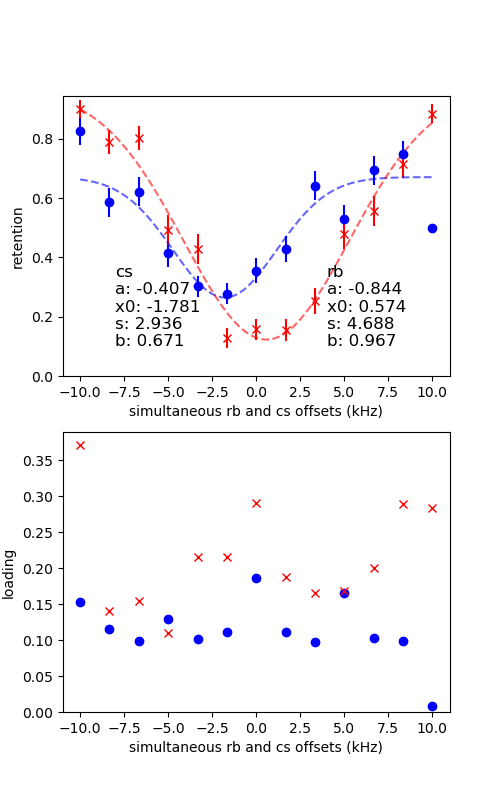

[-0.40660663 -1.78095165  2.93560837  0.67131435]
[-0.84393578  0.57420175  4.68781013  0.96674314]


In [14]:
# plotting
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
plt.subplots_adjust(wspace=0.3)
for i, yvals in enumerate(['retention', 'loading']):
    for e in range(len(retention['ivar'])):
        for r in range(2):            
            if yvals=='retention':
                try:
                    ax[i].errorbar(retention['ivar'][e, :, r], retention[yvals][e, :, r],
                        yerr=retention['error'][e,:,r],
                        fmt=fmt_map[r]
                    )
                except Exception as ee:
                    print(ee)
                    ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                # fitting
                xs = np.linspace(min(retention['ivar'][e, :, 0]), max(retention['ivar'][e, :, 0]),100)
                guess = [-0.6, retention['ivar'][e, np.argmin(retention[yvals][e, :, r]), 0], 4, 1.0]
                try:
                    popt, pcov = optimize.curve_fit(
                        gaussian,
                        retention['ivar'][e, :, 0],
                        retention[yvals][e, :, r],
                        p0=guess,
#                         sigma=retention['error'][e, :, r]
                    )
                except Exception as ee:
                    print ee
                else:
                    ax[i].plot(xs, gaussian(xs, *popt), fmt_map[r][0]+'--', alpha=0.6)
                    print(popt)
                    fit_data = "{}\na: {:.3f}\nx0: {:.3f}\ns: {:.3f}\nb: {:.3f}"
                    start = np.min(retention['ivar'][e, :, 0])
                    stop = np.max(retention['ivar'][e, :, 0])
                    dx = (stop-start)/10
                    ax[i].text(start+dx+r*6*dx, 0.1, fit_data.format(roi_map[r],*popt), fontsize=12)
            else:
                ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                
        
    ax[i].set_ylim(0., 1.05*np.nanmax(retention[yvals]))
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(yvals)

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'loading_scan.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)